# Seismic Geometry tutorial: part 1

One of the crucial parts of our framework is a `SeismicGeometry` class that holds information about the underlying cube of amplitudes in different data formats (**SEG-Y**, **HDF5**, **BLOSC**) and their versions with compression using quantization (**QHDF5**, **QBLOSC**). The main capabilities of `SeismicGeometry` are:

- infer information about traces in the cube based on one or more headers
- collect spatial and integral statistics about amplitude values
- provide methods for loading actual data from the desired location
- convert **SEG-Y** cubes to more efficient file formats that take less storage

To create a `SeismicGeometry` instance for a **SEG-Y** cube, we need to supply a path to the cube and the headers that would be used to uniquely identify each of the traces: those headers are used as an index to access underlying data. Note that we only load more than one trace into memory when we specifically ask for it: all information collection is done sequentially, without requiring too much RAM.

The `SeismicGeometry` tutorial is split into two parts. The **first part** demonstrates a number of methods and properties that help us to **examine the geology**:

* [Post-stack cube with INLINE_3D/CROSSLINE_3D headers](#headers)
* [First look at geological properties](#stats)
* [Loading cube data slices](#cube_slices)

And in the [**second part**](./01_Geometry_part_2.ipynb) you will learn more about **different data formats** and **saving processed data**.

In [1]:
# All the necessary imports
import os
import sys
import numpy as np
from time import perf_counter
from matplotlib import pyplot as plt

sys.path.append('..')
from seismiqb import SeismicGeometry, plot_image

<a id='headers'></a>
# Post-stack: INLINE_3D/CROSSLINE_3D headers

First of all, we instantiate a cube. Besides cube location on the disk, we need to specify:

- headers to store for each trace
- which of the headers are used as a unique identifier of a trace: it must be a subset of `headers`
- whether to collect amplitude statistics and spatial stats

Post-stack is a cube after multiple processing steps: it is already summed, and each trace has a dedicated `inline` and `crossline`.

By default, we load  `INLINE_3D, CROSSLINE_3D, CDP_Y, CDP_X` headers and use the first two for indexing.

In [2]:
%%time
geometry = SeismicGeometry(path='/data/seismic_data/seismic_interpretation/001_YETYPUR/001_YETYPUR.sgy',
                           collect_stats=True, spatial=True, recollect=True, pbar='t')

print(geometry)

Finding min/max: 100%|█████████████| 3611267/3611267 [01:21<00:00, 44440.73it/s]



Processed geometry for cube    /data/seismic_data/seismic_interpretation/001_YETYPUR/001_YETYPUR.sgy
Current index:                 ['INLINE_3D', 'CROSSLINE_3D']
Cube shape:                    (2563, 1409, 1501)
Time delay:                    50
Sample rate:                   2.0
Area:                          1522.4 km²

SEG-Y original size:           21.000 GB
Current cube size:             21.000 GB
Size of the instance:          1.106 GB

Number of traces:              3611267
Number of non-zero traces:     2435820
Fullness:                      0.67

Original cube values:
Number of uniques:                    192
mean | std:                          0.12 | 1887.29   
min | max:                      -47429.45 | 39240.19  
q01 | q99:                       -5459.50 | 5118.29   

CPU times: user 6min 12s, sys: 19.5 s, total: 6min 31s
Wall time: 6min 13s


A ```SeismicGeometry``` instance contains some information about the cube.
The following properties are available through the ```print``` call:
 * **Base info**: cube name, index headers, shape;
 * Info about **data collection**: time delay, sample rate;
 * **Сomputed info**: approximate area in squared kilometers;
 * **Storage** parameters;
 * **Traces info**: total amount, amount of meaningful traces and their proportion;
 * **Cube statistics** based on subsample of traces.

Moreover, this is not all what ```SeismicGeometry``` stored inside. We can save and get other things from an instance of this class:
 * Other **geometry properties** like depth, ranges, zero traces, quality map;
 * **Quantized statistics**;
 * **Statistical matrices**: mean, std, min, max;
 * **Signal-to-noise** ratio matrix;
 * **Cache statistics**: amount of cached slides (length), size.

A regular `pandas` dataframe describes cube structure, storing all the passed `headers`:

In [3]:
geometry.dataframe

trace_index   CDP_X    CDP_Y
INLINE_3D CROSSLINE_3D                              
24        19                      0  717115  7150315
          20                      1  717140  7150315
          21                      2  717165  7150315
          22                      3  717190  7150315
          23                      4  717215  7150315
...                             ...     ...      ...
2586      1423              3611262  752215  7214365
          1424              3611263  752240  7214365
          1425              3611264  752265  7214365
          1426              3611265  752290  7214365
          1427              3611266  752315  7214365

[3611267 rows x 3 columns]

***Note that our class can work with any indexing headers, not only the `inline`/`crossline` pair. Though, it is much preferred: those headers are represented by integer values, and their usage as an index is much more robust. A common flaw of a `cdp_x`/`cdp_y` index is that multiple `cdp_x` can correspond to one `crossline`. For example, `10.25`, `10.2501` values can be labeled as the first crossline, which makes the unique indexing much harder to impose.***

<a id='stats'></a>
# First look at geological properties

`inline`/`crossline` index provides a clear spatial structure, so we can collect spatial stats by passing `spatial=True` at initialization. It takes some time and creates several additional attributes:

- `min_matrix`, `max_matrix`, `mean_matrix`, `std_matrix` store minimum, maximum, average, and variance values for each of the cube traces
- `hist_matrix` stores a whole histogram of values for each trace: all of them are created with the same bins, so the distributions are directly comparable

Each `*_matrix` has the same dimensionality as the spatial range of the cube: we can see that the cube has 2563 inlines and 1409 crosslines, and each matrix has the same shape. Most of the cubes are padded with zero traces on the edges to have a rectangular shape; as there are no valuable stats for such traces, we fill their locations with NaNs inside every matrix, which corresponds to the white filling color on images:

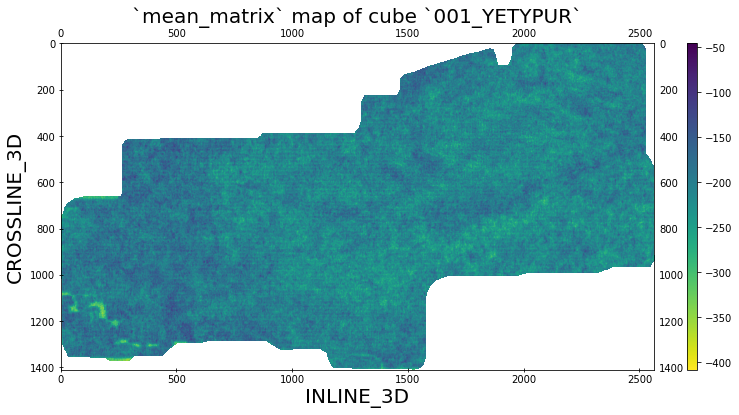

In [4]:
geometry.show(matrix='mean_matrix', figsize=(12, 6))

As has already been noticed, the size of the instance is quite large. Most of that size is occupied by the `trace_container` attribute, which stores many (default value is 15000) traces from the cube, raveled into one extremely long array. That storage is convenient when it comes to exploration of the actual amplitude values: it is big enough to reflect the actual amplitude distribution accurately, so it can be used to derive all kinds of conclusions about it. Several instance attributes are computed from this array, like `v_q01` (1% quantile of the amplitudes in the cube) and `v_q99` (the 99% quantile). 

The need for having such statistics is not only for exploration: as every cube traces lie in different ranges, we need to scale the amplitudes down to the same interval, for example, to $[-1; 1]$. Computing stats from each batch of data would be inefficient and inaccurate: that is where precomputing all of them comes in handy.

***`keep_num` argument of the `SeismicGeometry` initialization allows controlling the number of stored traces.***

Size of the trace container: 0.07547 GB
Number of stored traces: 6748
1% and 99% quantiles of the amplitudes: -5459.50, 5118.29


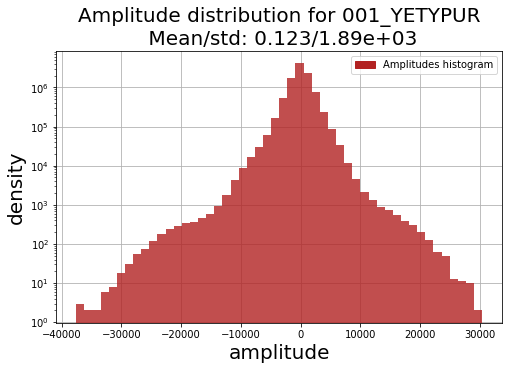

In [5]:
tc = geometry.trace_container

print(f'Size of the trace container: {tc.nbytes / (1024 ** 3):4.4} GB')
print(f'Number of stored traces: {len(tc) // geometry.depth}')
print(f'1% and 99% quantiles of the amplitudes: {geometry.v_q01:.2f}, {geometry.v_q99:.2f}')

geometry.show_histogram(hist_log=True)

To speed up the instance initialization, we keep all of the collected stats near the cube in a ```*.meta``` file in HDF5 format and use it for subsequent initializations.

To force re-creation of ```*.meta``` file (instead of loading stats from it) during processing, pass `recollect=True` at initialization, just as we did.

<a id='cube_slices'></a>
# Loading cube data slices

One of the main usages of `SeismicGeometry` is to load slices of amplitudes. We use the `load_slide` method, which takes a number of a slice that we want to load. The loading acts along the specified axis (0 by default), corresponding to a `INLINE_3D` in our case. 

In [6]:
%%time
slide = geometry.load_slide(loc=30, axis=0)

CPU times: user 36.6 ms, sys: 8.11 ms, total: 44.7 ms
Wall time: 43.1 ms


All of the actual data loading is heavily cached: so, if we load the same slice the second time, it is performed almost instantaneously:

In [7]:
%%time
slide = geometry.load_slide(loc=30, axis=0)

CPU times: user 41 µs, sys: 4 µs, total: 45 µs
Wall time: 52.7 µs


That behavior is beneficial when loading thousands of slices, for example, in the process of neural network training. Note that the amount of speedup achieved by caching may vary depending on the exact sampling procedure: if we are repeatedly accessing the same slices, which would always be cached, the load would always be high-speed; on the other hand, if we are to generate uniformly random slices from the entire cube, the effect would not be that noticeable.

We can easily **introspect** caching:

In [8]:
print(f"Amount of cached slides: {geometry.cache_length}") # just one slide
print(f"Size of cached slides: {geometry.cache_size}")

Amount of cached slides: 1
Size of cached slides: 0.007878649979829788


and **reset** cache:

In [9]:
geometry.reset_cache()

print(f"Amount of cached slides: {geometry.cache_length}")
print(f"Size of cached slides: {geometry.cache_size}")

Amount of cached slides: 0
Size of cached slides: 0


**lru caching strategy** is speedy: it takes **O(1)** to access or updates an item. Cache can be of great help, when the cube data is accessed repeteadly in the same slices. In some other scenarios, when the traces are sampled uniformly, it is not that useful and can be disabled with `use_cache=False` argument.

By default, we store no more than 128 slices in the cache: the next entries would override the oldest item.

In [10]:
for i in range(128+5): # 128 is a cache limit for load_slide
    slide = geometry.load_slide(loc=i)

print(f"Amount of cached slides: {geometry.cache_length}")
print(f"Size of cached slides: {geometry.cache_size:.4f}\n")

geometry.reset_cache()

print(f"Amount of cached slides: {geometry.cache_length}")
print(f"Size of cached slides: {geometry.cache_size}")

Amount of cached slides: 128
Size of cached slides: 1.0085

Amount of cached slides: 0
Size of cached slides: 0


Also, we can load **3d data**, in **cached** (as set of slides) and **not cached** manner:

In [11]:
# not cached:
crop = geometry.load_crop(locations=[slice(0, 100), slice(0, 100), slice(0, 100)])

print(f"Crop shape: {crop.shape}")
print(f"Amount of cached slides: {geometry.cache_length}")
print(f"Size of cached slides: {geometry.cache_size}\n")


# cached:
crop = geometry.load_crop(locations=[slice(0, 100), slice(0, 100), slice(0, 100)], mode='slide')

print(f"Crop shape: {crop.shape}")
print(f"Amount of cached slides: {geometry.cache_length}")
print(f"Size of cached slides: {geometry.cache_size:.4f}\n")

geometry.reset_cache()

Crop shape: (100, 100, 100)
Amount of cached slides: 0
Size of cached slides: 0

Crop shape: (100, 100, 100)
Amount of cached slides: 100
Size of cached slides: 0.7879



For convenience, the square brackets allow working with an instance of `geometry` like with any regular 3D array and load data into memory. Under the hood it uses the not cached version of the `load_crop` method.

In [12]:
%%time
print(f"Entire cube:\n    {geometry.shape}\n    {geometry[:, :, :].shape}\n")
print(f"Crop:\n    {geometry[700:900, 200:600, 0:30].shape}\n")
print(f"Slide:\n    {geometry[100, :].shape}\n    {geometry[:, 10].shape}\n    {geometry[:, :, 0].shape}\n")

Entire cube:
    (2563, 1409, 1501)
    (2563, 1409, 1501)

Crop:
    (200, 400, 30)

Slide:
    (1409, 1501)
    (2563, 1501)
    (2563, 1409)

CPU times: user 57.4 s, sys: 14.3 s, total: 1min 11s
Wall time: 1min 11s


# Visualization

Method `show_slide` acts exactly like `load_slide` does and works with the same parameters, but displays the data instead of returning it.

***Note:*** just like any other plot in our library, it automatically parses `matplotlib` arguments and uses them in right places. To learn more about it, check out our [plotting tutorial](./plotters/01_imshow.ipynb)! 

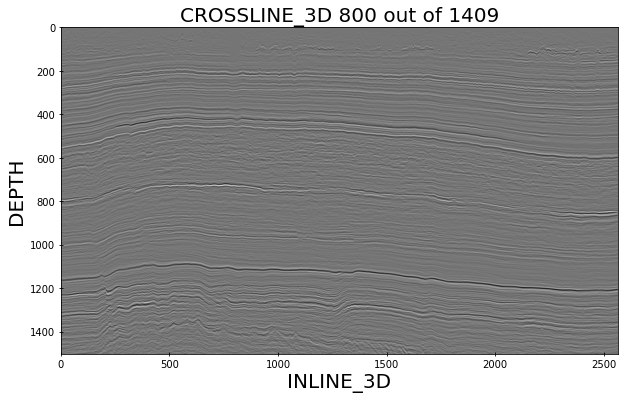

In [13]:
geometry.show_slide(loc=800, axis=1, figsize=(12, 6))

As the bottom of the slide is very noisy and does not provide much insight, we would like to zoom in. `zoom_slice` parameter does exactly that:

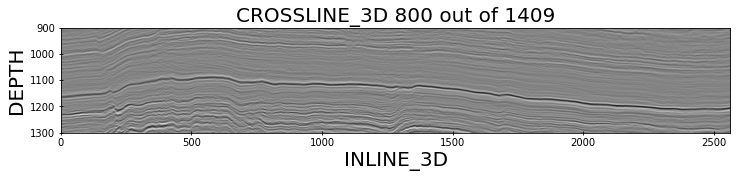

In [14]:
geometry.show_slide(loc=800, axis=1, figsize=(12, 6),
                    zoom_slice=(slice(None), slice(900, 1300)))

Sometimes, change of colormap helps to distinguish reflections such as horizons and faults:

***We also zero-center the image by passing `vmin` and `vmax` values.***

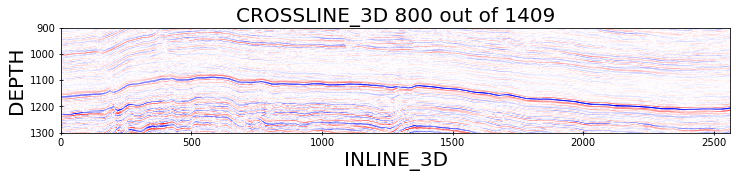

In [15]:
geometry.show_slide(loc=800, axis=1, figsize=(12, 6),
                    zoom_slice=(slice(None), slice(900, 1300)),
                    cmap='seismic', vmin=-20000, vmax=20000)

You can also take a closer look at instantaneous phases using [wiggle plot](http://www.fatiando.org/v0.5/gallery/vis/seismic-wiggle.html):

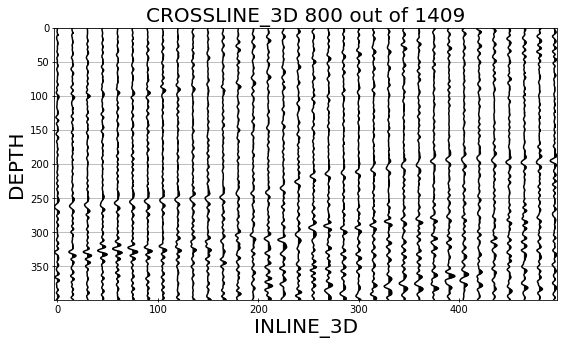

In [16]:
geometry.show_slide(loc=800, axis=1, figsize=(9, 5),
                    zoom_slice=(slice(0, 500), slice(900, 1300)),
                    mode='wiggle', xstep=12)

# Conclusion

This concludes the **first part** of the `SeismicGeometry` tutorial: it showed how to dive into geological data with the `SeismicGeometry` class. Specifically, you have learned how to:

- infer geological properties like SNR of seismic cubes
- load actual slices of seismic data, as well as visualize them
- display simple amplitude distribution statistics

The [second part](./01_Geometry_part_2.ipynb) shows data loading optimizations and saving new data cubes.